In [4]:
# both envs require
import os

In [2]:
import arcpy

In [1]:
import contextily as ctx
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib.ticker import ScalarFormatter
import rasterio
import fiona
from rasterio.plot import show, show_hist
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
ExtensionName = 'Spatial'
if arcpy.CheckExtension(ExtensionName) == "Available":
        arcpy.CheckOutExtension(ExtensionName)

In [21]:
arcpy.env.workspace = r'T:\DCProjects\StoryMap\Models\UrbanSim\UrbanSim.gdb'
arcpy.env.overwriteOutput = True
arcpy.env.extent = "V:/Data/Transportation/MPO_Bound.shp"

In [2]:
path = r'T:\Trans Projects\Model Development\UrbanSim_LandUse\Output\Simulation_47_Final_RTP'

In [5]:
newDev = gpd.read_file(os.path.join(path, 'new_developments.shp'))

In [6]:
newDev.crs

<Projected CRS: PROJCS["NAD83_HARN_Oregon_South_ft",GEOGCS["GCS_NA ...>
Name: NAD83_HARN_Oregon_South_ft
Axis Info [cartesian]:
- [east]: Easting (foot)
- [north]: Northing (foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [29]:
list(newDev.columns)

['btype',
 'nsqft',
 'rsqft',
 'du',
 'yrbuilt',
 'lpid',
 'pundev',
 'dev_land',
 'orsqft',
 'onrsqft',
 'odu',
 'dua',
 'nrfar',
 'ndu',
 'nnsqft',
 'geometry']

In [283]:
len(newDev['yrbuilt'].unique())

25

In [30]:
newDev['ndu'].min(), newDev['ndu'].max()

(-535, 700)

In [31]:
newDev['nnsqft'].min(), newDev['nnsqft'].max()

(-461328.0, 1037863.0)

In [3]:
yrbuilt = 2021

In [22]:
def createHeatmap(yrbuilt = 2021, field = "nnsqft"):
    arcpy.FeatureToPoint_management(in_features=os.path.join(path, 'output', 'newDevAnn' + str(yrbuilt) +'.shp'), 
                                out_feature_class="newDevCentroid", point_location="INSIDE")
    arcpy.gp.KernelDensity_sa("newDevCentroid", field, 
                          os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + ".tif"),
                          "100","", "SQUARE_KILOMETERS", "DENSITIES", "GEODESIC")

In [4]:
def reprojection(yrbuilt = 2021, field = "nnsqft", dst_crs = 'EPSG:3857'):
    with rasterio.open(os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + ".tif")) as src:
            transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            with rasterio.open(os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_3857.tif"), 
                               'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
    src.close()
    dst.close()

In [5]:
def maskRaster(yrbuilt = 2021, field = "nnsqft", maskFile = "V:/Data/Transportation/MPO_Bound.shp"):
    dataset = rasterio.open(os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_3857.tif"))
    with fiona.open(maskFile, "r") as vectorfile:
        shapes = [feature["geometry"] for feature in vectorfile]
    out_image, out_transform = mask(dataset=dataset, shapes=shapes, crop=True)
    out_meta = dataset.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    file = os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_clipped.tif")
    with rasterio.open(file, "w", **out_meta) as dest:
        dest.write(out_image)
    dataset.close()
    dest.close()

In [23]:
createHeatmap(yrbuilt = 2041, field = "ndu")

In [100]:
reprojection(yrbuilt = 2041, field = "ndu")

In [101]:
maskRaster(yrbuilt = 2041, field = "ndu")

In [102]:
yrbuilt = 2041
field = "ndu"
file = os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_clipped.tif")
raster = rasterio.open(file)

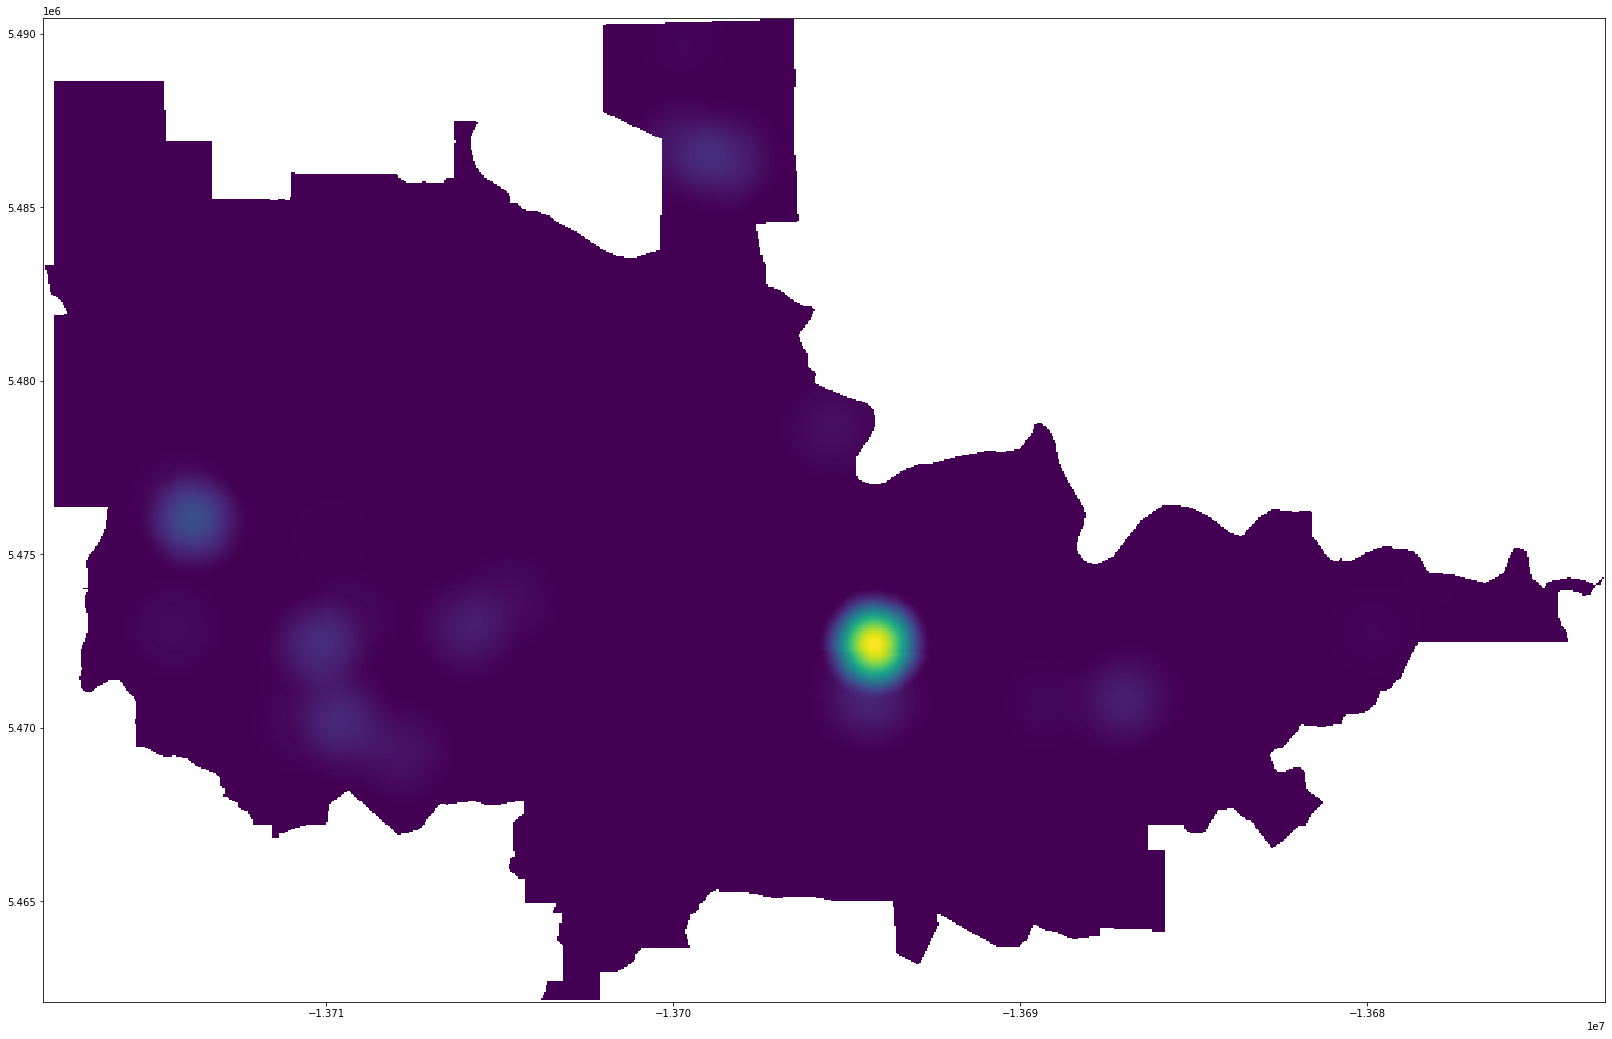

<AxesSubplot:>

In [103]:
fig, ax = plt.subplots(1, figsize=(28, 24))
show(raster)

In [12]:
raster.close()

for yrbuilt in range(2021, 2046, 1):
    #createHeatmap(yrbuilt = yrbuilt)
    createHeatmap(yrbuilt = yrbuilt, field = "ndu")
    print("Processed " + str(yrbuilt) + "...")

for yrbuilt in range(2021, 2046, 1):
    reprojection(yrbuilt = yrbuilt)
    maskRaster(yrbuilt = yrbuilt)
#     reprojection(yrbuilt = yrbuilt, field = "ndu")
#     maskRaster(yrbuilt = yrbuilt, field = "ndu")    
    print("Processed " + str(yrbuilt) + "...")

In [105]:
outpath = r'T:\Models\StoryMap\UrbanSim'

In [73]:
MPObd = gpd.read_file("V:/Data/Transportation/MPO_Bound.shp")

In [340]:
# test
yrbuilt = 2045
field = "nnsqft"
file = os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_clipped.tif")
src = rasterio.open(file, mode="r+")

In [341]:
src.read(1).min()

-3.4028235e+38

In [342]:
src.read(1).max()

81055550.0

In [343]:
data = src.read(1)

In [344]:
ndata = np.where(data == data.min(), np.nan, data)

In [148]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [299]:
data_ex = data[data != data.min()]

In [300]:
norm = MidpointNormalize(vmin = data_ex.min(), vmax = data.max(), midpoint=0) 

In [347]:
data_ex.min()

0.0

In [345]:
cmap = 'Reds'

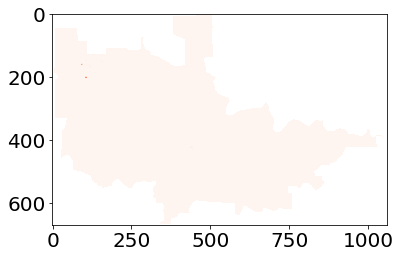

<AxesSubplot:>

In [346]:
show(ndata, cmap=cmap)

In [248]:
def getMinMax(field):
    vmin = []
    vmax = []
    for yrbuilt in range(2021, 2046, 5):
        file = os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_clipped.tif")
        src = rasterio.open(file, mode="r+")
        data = src.read(1)
        data_ex = data[data != data.min()]
        vmin.append(data_ex.min())
        vmax.append(data.max())
    return min(vmin), max(vmax)

In [269]:
field = "nnsqft"

In [270]:
getMinMax(field=field)[1]

7340180.0

In [267]:
int(round(getMinMax(field=field)[1], 0))

285

In [350]:
#nnsqft: vmin = -780000, vmax = 7400000
#ndu: vmin = -8, vmax = 285
def plotRaster(yrbuilt = 2021, field = "nnsqft", fieldName = 'New Non-res SQFT', colormap = 'RdBu_r', 
                export = True):
    file = os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_clipped.tif")
    src = rasterio.open(file, mode="r+")
    fig, ax = plt.subplots(figsize=(28, 24))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad="2%")
    
    # plot on the same axis with rio.plot.show
    data = src.read(1)
    ndata = np.where(data == data.min(), np.nan, data)
#     norm = MidpointNormalize(vmin = int(round(getMinMax(field=field)[0], 0)), 
#                              vmax = int(round(getMinMax(field=field)[1], 0)), 
#                              midpoint=0)
    data_ex = data[data != data.min()]
    norm = MidpointNormalize(vmin = data_ex.min(), vmax = data.max(), midpoint=0)
    
    if data_ex.min() == 0: 
        image = show(ndata, 
                     transform=src.transform, 
                     ax=ax, 
                     cmap="Reds")
    else:
        image = show(ndata, 
                     transform=src.transform, 
                     ax=ax, 
                     cmap=colormap, 
                     norm=norm)
        
    MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--')
    
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, alpha=0.3)
    ax.set_title(fieldName + " Heatmap in Central Lane MPO (" + str(yrbuilt) + ")", fontsize=50, fontname="Palatino Linotype", 
                  color="grey", loc = 'center')
    
    if yrbuilt in [2044, 2045] and field == "nnsqft":
        # use imshow so that we have something to map the colorbar to
        image_hidden = ax.imshow(ndata, 
                                 cmap="Reds")    
    else:
        image_hidden = ax.imshow(ndata, 
                                 cmap=colormap, 
                                 norm=norm)
    # add colorbar using the now hidden image
#     cb = fig.colorbar(image_hidden, ax=ax, cax=cax)
#     cb.formatter.set_powerlimits((0, 0))
#     cb.ax.yaxis.set_offset_position('left')
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    cbar = plt.colorbar(image_hidden, format=fmt, ax=ax, cax=cax, orientation="horizontal")

#     cbar = plt.colorbar(image_hidden, ax=ax, cax=cax)
#     cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.0f'))
    
    #cb.ax.tick_params(labelsize=20)
#     cb.update_ticks()
    
    mpl.rcParams.update({'font.size': 20})

    ax.axis("off");
    if export:
        plt.savefig(os.path.join(outpath, "heatmap_" + field + "_" + str(yrbuilt) + ".png"), transparent=True, bbox_inches='tight')
        print("Saved image for " + str(yrbuilt) + "...")
    src.close()

In [336]:
#test
yrbuilt = 2045
field = "nnsqft"
fieldName = 'New Non-res SQFT'
colormap = 'RdBu_r'
export = False

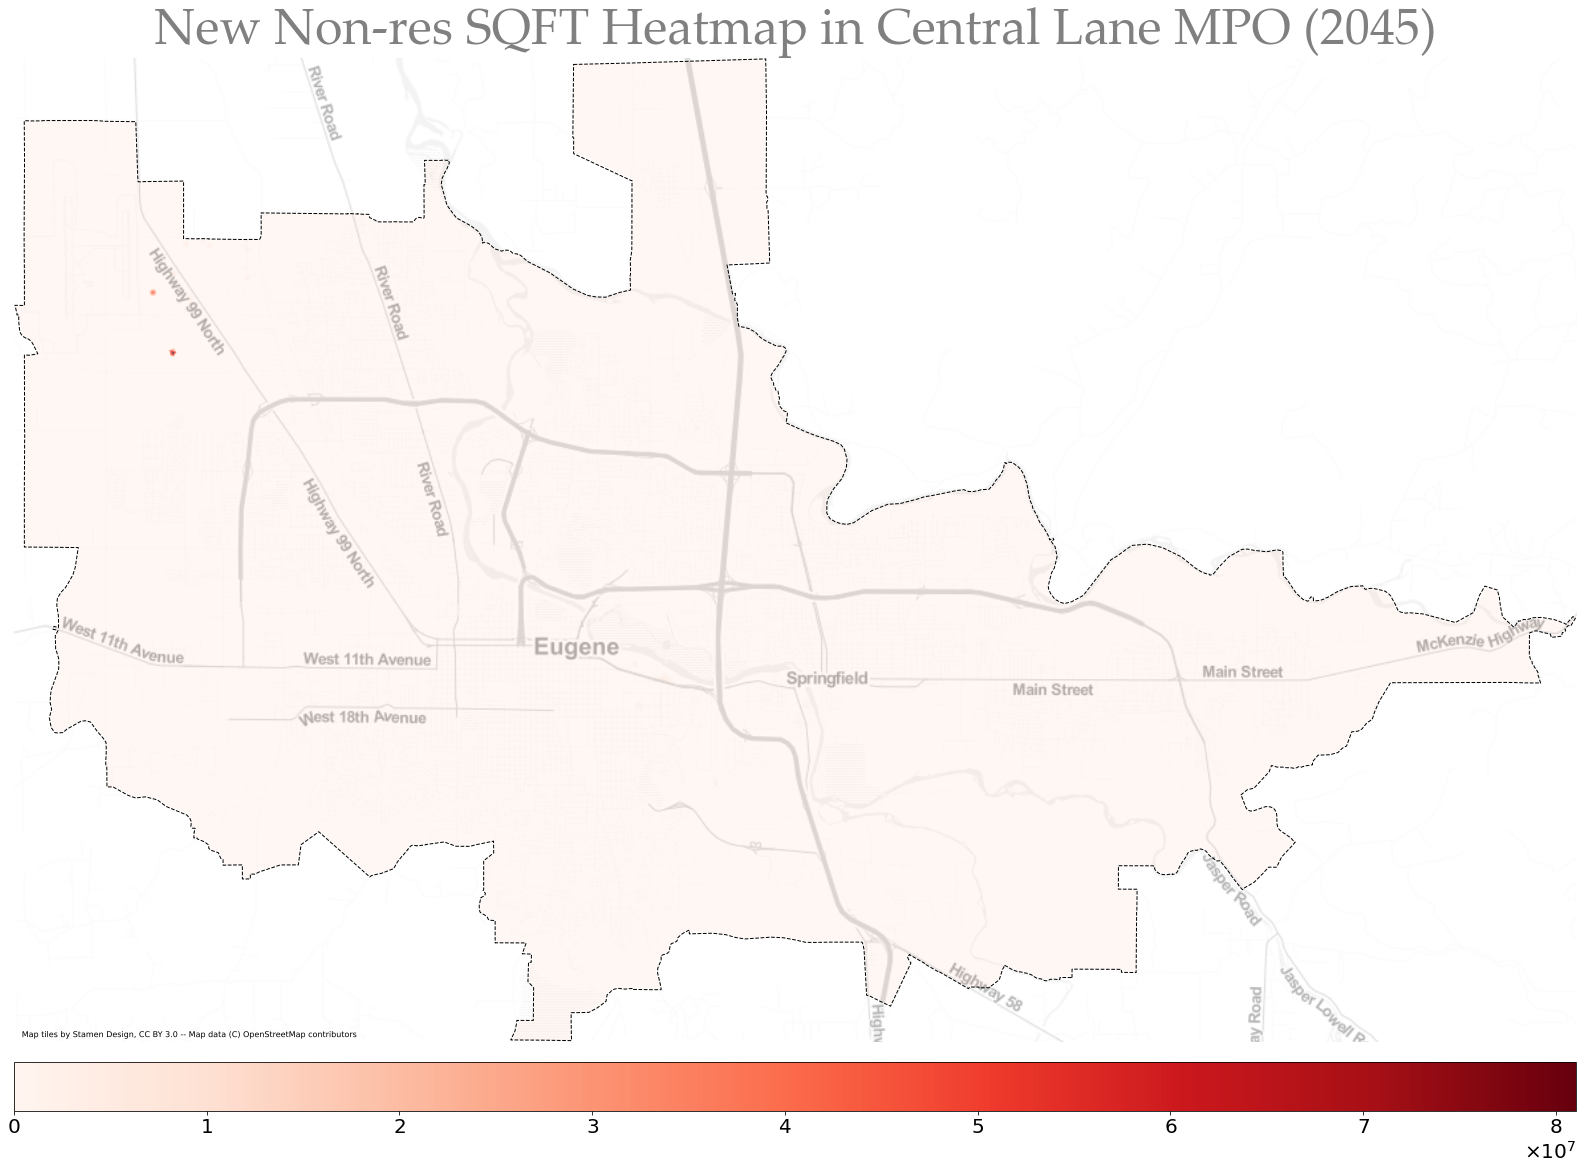

In [337]:
#test
file = os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_clipped.tif")
src = rasterio.open(file, mode="r+")
fig, ax = plt.subplots(figsize=(28, 24))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad="2%")
# plot on the same axis with rio.plot.show
data = src.read(1)
ndata = np.where(data == data.min(), np.nan, data)
#     norm = MidpointNormalize(vmin = int(round(getMinMax(field=field)[0], 0)), 
#                              vmax = int(round(getMinMax(field=field)[1], 0)), 
#                              midpoint=0)
data_ex = data[data != data.min()]

image = show(ndata, 
             transform=src.transform, 
             ax=ax, 
             cmap="Reds")

MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--')

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, alpha=0.3)
ax.set_title(fieldName + " Heatmap in Central Lane MPO (" + str(yrbuilt) + ")", fontsize=50, fontname="Palatino Linotype", 
              color="grey", loc = 'center')

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(ndata, 
                         cmap="Reds")

# add colorbar using the now hidden image
#     cb = fig.colorbar(image_hidden, ax=ax, cax=cax)
#     cb.formatter.set_powerlimits((0, 0))
#     cb.ax.yaxis.set_offset_position('left')
fmt = mpl.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
cbar = plt.colorbar(image_hidden, format=fmt, ax=ax, cax=cax, orientation="horizontal")

#     cbar = plt.colorbar(image_hidden, ax=ax, cax=cax)
#     cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.0f'))

#cb.ax.tick_params(labelsize=20)
#     cb.update_ticks()

mpl.rcParams.update({'font.size': 20})

ax.axis("off");

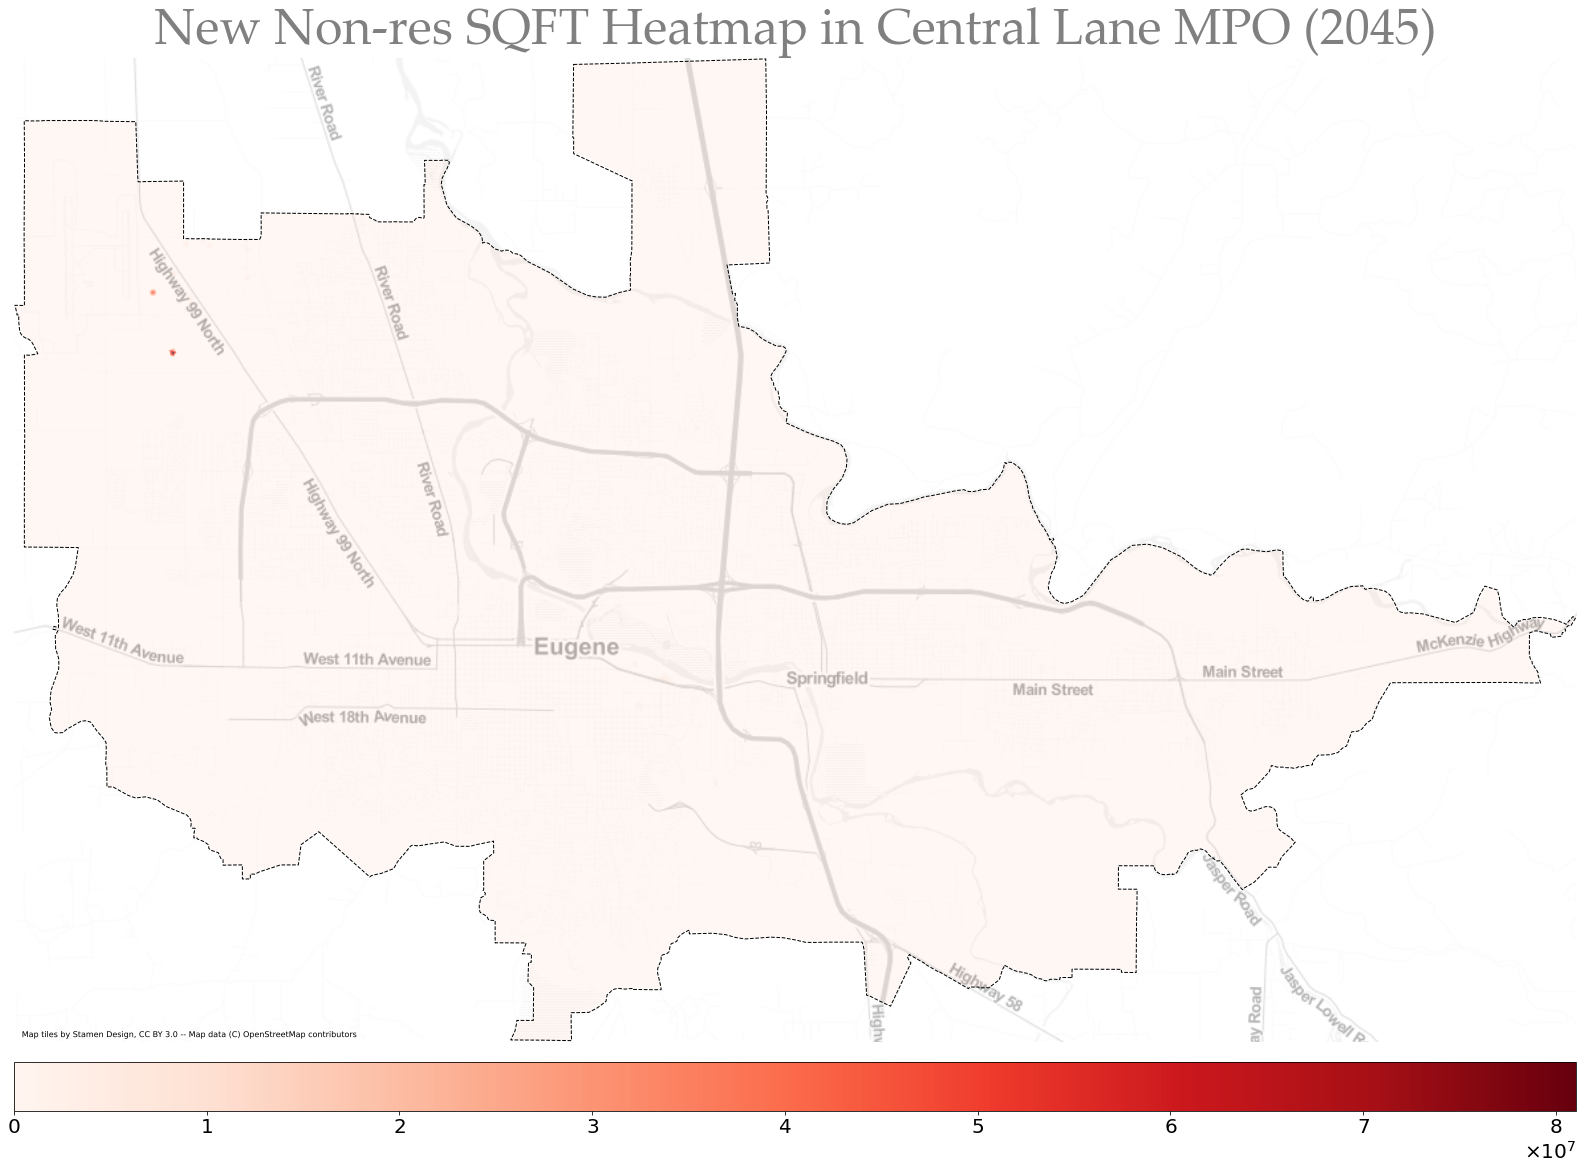

In [351]:
plotRaster(yrbuilt = 2045, export = False)

for yrbuilt in range(2021, 2046, 1):
    plotRaster(yrbuilt = yrbuilt)

for yrbuilt in range(2021, 2046, 1):
    plotRaster(yrbuilt = yrbuilt, field = "ndu", fieldName = 'New Dwelling Units')